In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [14]:
plt.style.use('dark_background')

In [2]:
base_dir = '/data/severstal-steel-defect-detection/'
train_df = pd.read_csv(base_dir+'/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [23]:
def read_image(imageId):
    sample_image_df = train_df[train_df['ImageId'] == imageId]
    sample_path = base_dir+"train_images/{}".format(sample_image_df['ImageId'].iloc[0])
    sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    sample_rles = sample_image_df['EncodedPixels'].values
    sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
    
    return sample_img, sample_masks

In [20]:
def get_segment(start_width, start_height, segment_width, segment_height, sample_img, sample_masks):
    
    if start_width + segment_width > sample_img.shape[1]:
        raise IndexError("width inputs exceed image size (start_width: {}, segment_width: {}, image_width: {}, OVER_BY: {})".format(start_width, segment_width, sample_img.shape[1], start_width+segment_width-sample_img.shape[1]))
    elif start_height + segment_height > sample_img.shape[0]:
        raise IndexError("height inputs exceed image size (start_height: {}, segment_height: {}, image_height: {}, OVER_BY: {})".format(start_height, segment_height, sample_img.shape[0], start_height+segment_height-sample_img.shape[0]))
    
    return sample_img[start_height:start_height+segment_height, start_width:start_width+segment_width], sample_masks[start_height:start_height+segment_height, start_width:start_width+segment_width,:]
    

In [10]:
def show_images(image, masks):
    
    fig, axs = plt.subplots(5, figsize=(12, 12))
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Raw')

    for i in range(4):
        axs[i+1].imshow(masks[:, :, i])
        axs[i+1].axis('off')
        axs[i+1].set_title('Defect {}'.format(i+1))

In [24]:
img, masks = read_image(train_df.ImageId.values[0])

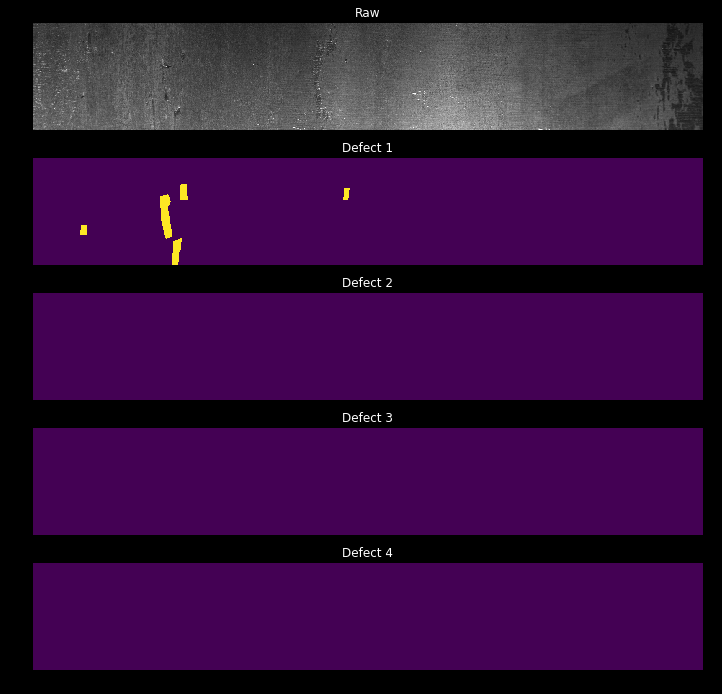

In [25]:
show_images(img,masks)

In [26]:
segment_img, segment_masks = get_segment(0, 0, 500, 100, img, masks)

In [39]:
segment_masks.sum(axis=0).sum(axis=0)

array([810.,   0.,   0.,   0.])

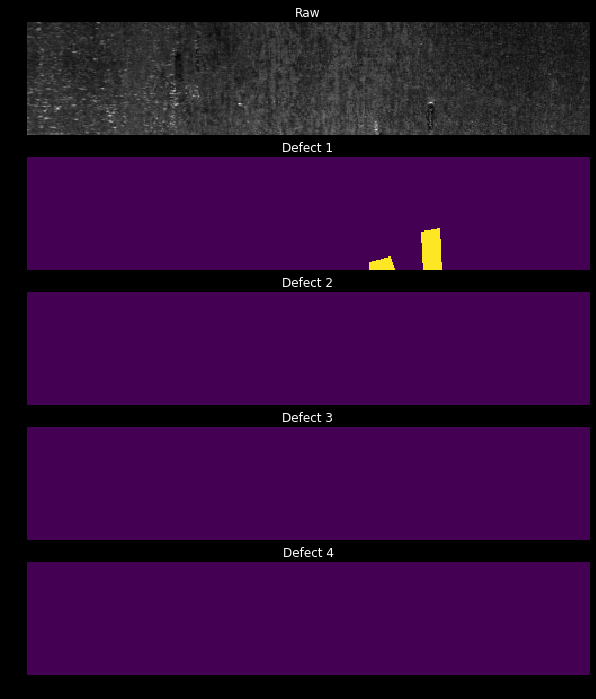

In [27]:
show_images(segment_img, segment_masks)

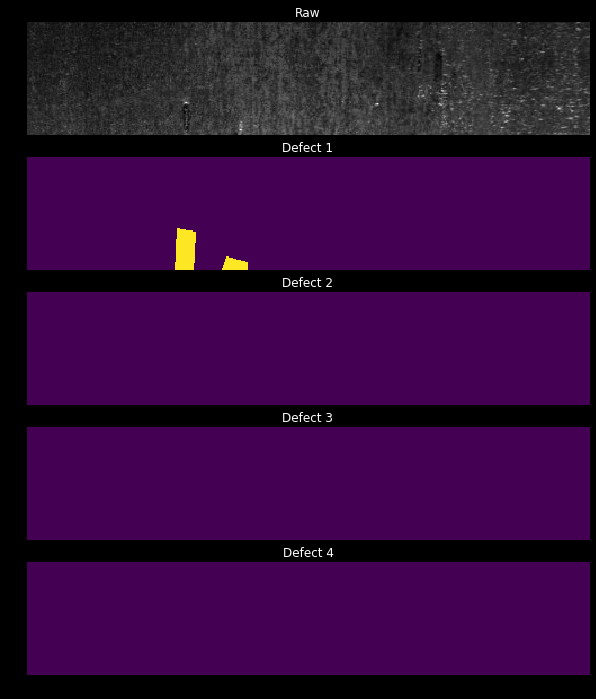

In [44]:
show_images(segment_img[:,::-1], segment_masks[:,::-1,:])

In [ ]:
show_

In [68]:
def split_image(imageId, segment_width=224, segment_height=224, width_step=32, height_step=32, rotate_horizontal=False, rotate_vertical=False):
    
    img, masks = read_image(imageId)
    
    img_height, img_width  = img.shape

    to_return = []

    for h in range(0, img_height, height_step):
        for w in range(0, img_width, width_step):

            if w + segment_width > img_width:
                continue
            elif h + segment_height > img_height:
                continue

            segment_img, segment_masks = get_segment(w, h, segment_width, segment_height, img, masks)

            defect_pixel_counts = segment_masks.sum(axis=0).sum(axis=0)
            classes_present = np.sum(defect_pixel_counts>0)

            for d, dpc in enumerate(defect_pixel_counts):
                to_return.append([imageId, '{}_{}_{}_{}'.format(w,h,segment_width,segment_height), d+1, dpc, classes_present, mask2rle(segment_masks[:,:,d])])
                
    return pd.DataFrame(to_return, columns = ['ImageId','Key','Defect','DefectPixels','ClassesPresent','EncodedPixels'])
            

In [69]:
tmp = split_image(train_df.ImageId.values[0])

In [70]:
tmp.head()

,ImageId,Key,Defect,DefectPixels,ClassesPresent,EncodedPixels
0,0002cc93b.jpg,0_0_224_224,1,341.0,1,25486 12 25698 24 25922 24 26146 24 26370 24 2...
1,0002cc93b.jpg,0_0_224_224,2,0.0,1,
2,0002cc93b.jpg,0_0_224_224,3,0.0,1,
3,0002cc93b.jpg,0_0_224_224,4,0.0,1,
4,0002cc93b.jpg,32_0_224_224,1,341.0,1,18318 12 18530 24 18754 24 18978 24 19202 24 1...


In [ ]:
def add_segment(start_width, start_height, image_width, image_height):
    
    return blah

In [ ]:
def reconstruct_image

In [ ]:
def splitImg(train_df, files):
    out = []
    #Properties
    xres = 224
    yres = 224
    xstep = 32
    ystep = 32
    
    #load_file
    for f in files:
        image_df = train_df[train_df['ImageId'] == f]
        path = "train_images/{}".format(image_df['ImageId'].iloc[0])
        img = cv2.imread(path,0)
        rles = image_df['EncodedPixels'].values
        masks = build_masks(rles, input_shape=(256, 1600))
    
        #Step over image to create window
        for x in range(0, img.shape[0], xstep):
            for y in range(0, img.shape[1], ystep):
                #Check window will fit
                if((x + xres > img.shape[0]) or (y + yres > img.shape[1])):
                    continue
                imgT = img[x:x+xres, y:y+yres]
                masksT = masks[x:x+xres, y:y+yres]
                classes = np.argwhere(masksT.T.reshape(4,224*224).max(axis=1))
                #Check mask is present
                for z in classes:
                    out.append(["{}_{}".format(f,z[0]), "{}_{}".format(x,y), z[0], mask2rle(masksT)])
                if(len(classes) == 0):
                    #if there is no mask in the image take 5%
                    if(0.95 < random.random()):
                        out.append(["{}_{}".format(f,"none"), "{}_{}".format(x,y), "none", mask2rle(masksT)])
    
    return pd.DataFrame(out, columns = ["id", "x_y", "classID", "encoded"])